# Some small tests on kernelized concept erasure

### Question: Can I fully reconstruct the original image from the flattened patches?

In [1]:
import torch
import numpy as np
from PIL import Image
import pickle

In [2]:
patches_file = "pos_train_patches.pickle"

import pickle
with open("../data/pos/representations/" + patches_file, "rb") as f:
    patches = pickle.load(f)

reprs_file = "pos_train_visual.pickle"
with open("../data/pos/representations/" + reprs_file, "rb") as f:
    reprs = pickle.load(f)

In [3]:
img_id = "0"
layer = 0
# patches[img_id].keys()
kernel_z = torch.from_numpy(reprs[img_id][layer])

In [4]:
import sys
sys.path.append("../../")
import Transformer_MM_Explainability.CLIP.clip as clip

In [5]:
def get_model_preprocess(device, model_type="ViT-B/32"):
    """
    ViT-L/14 seems to break things; because the transformer has 24 layers instead of 12
    """
    clip.clip._MODELS = {
        "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
        "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
        "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
    }
    model, preprocess = clip.load(model_type, device=device, jit=False)
    return model, preprocess

model, preprocess = get_model_preprocess("cpu")

/Users/avansprang/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


../data/pos/images/train/0.png
(1478, 1478)


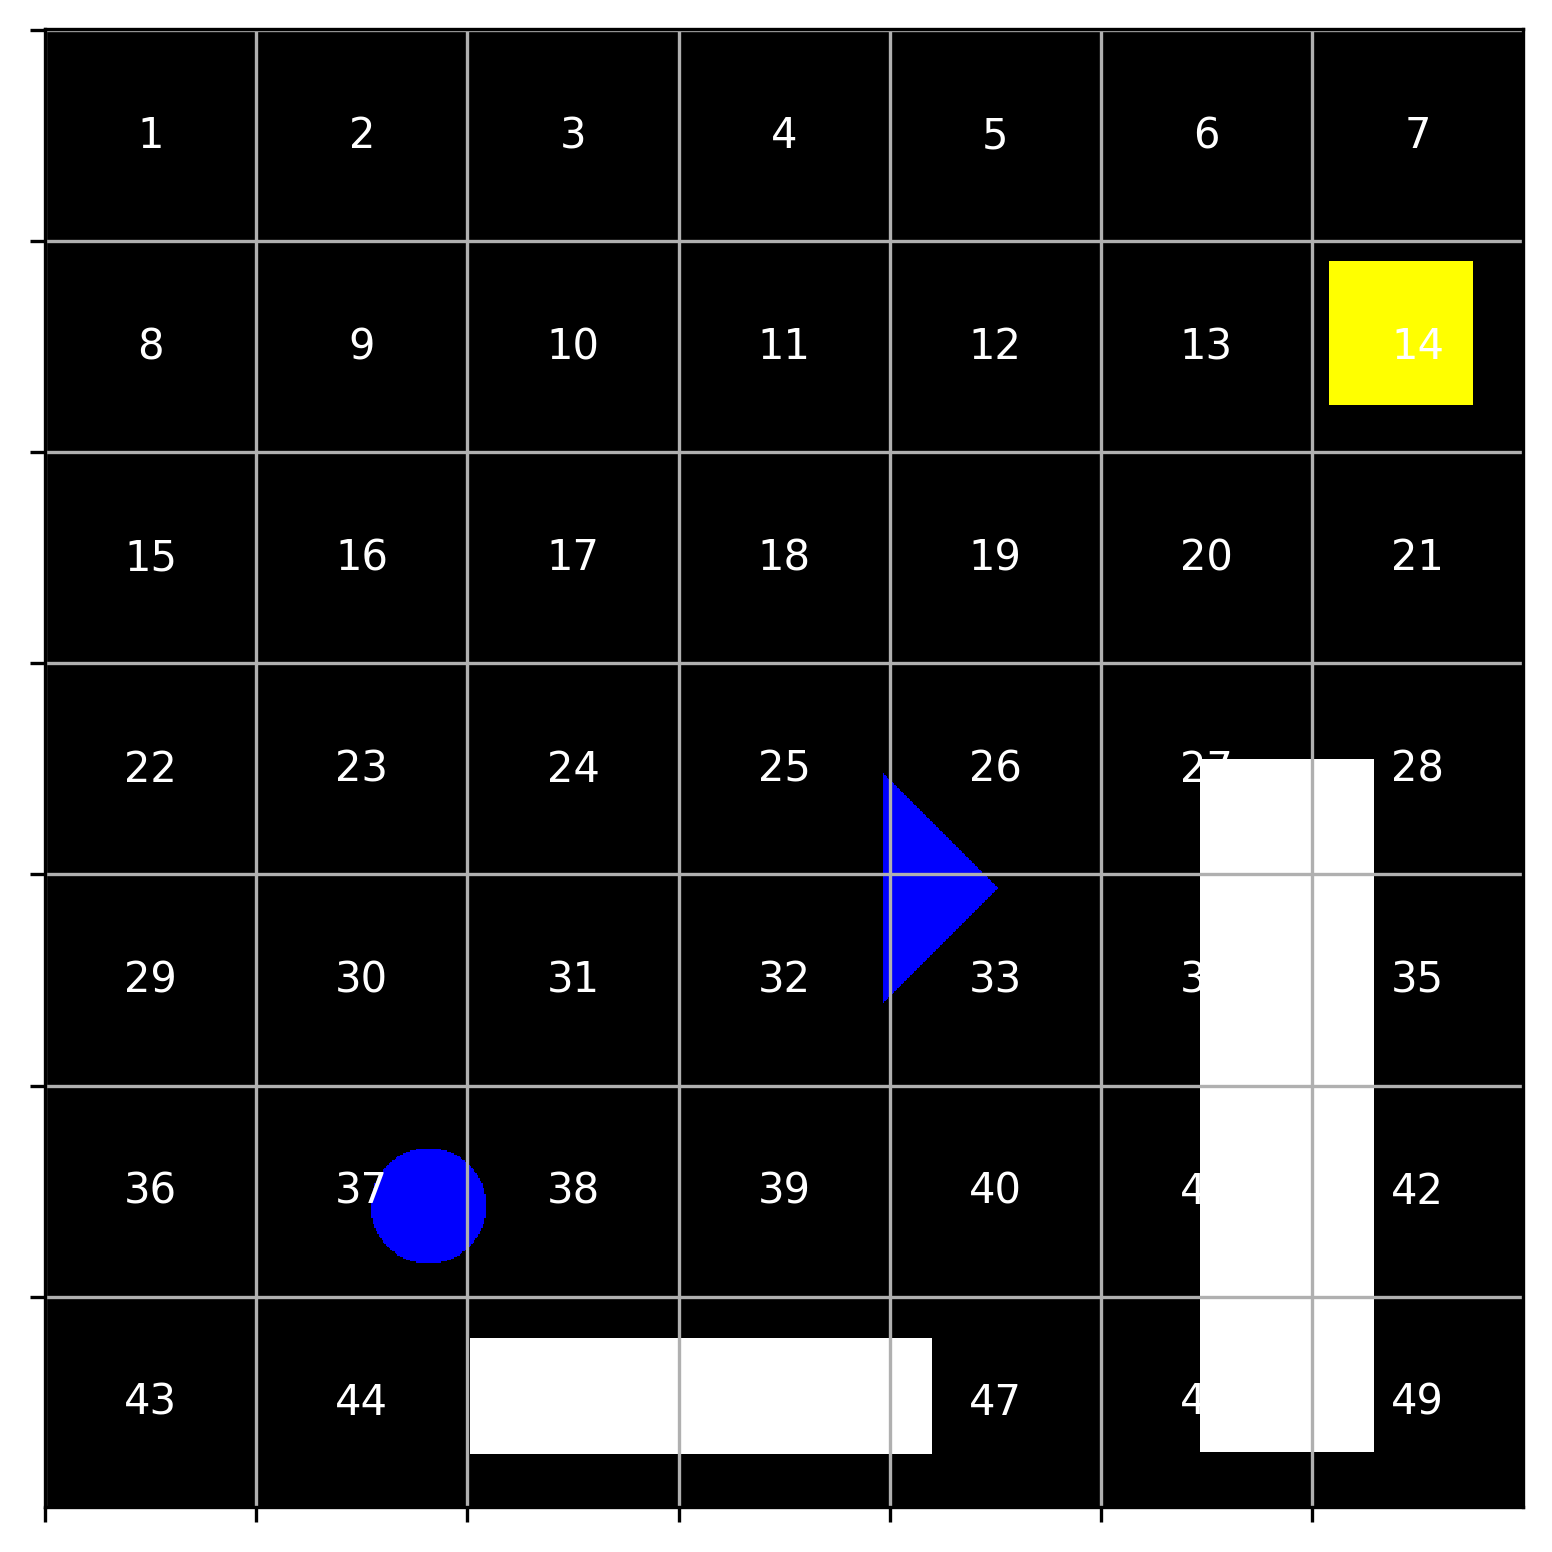

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from transformer_patches import open_image_withpatches

open_image_withpatches("0.png", "pos", "train", to_save=False)

In [7]:
from transformer_patches import get_all_patches_with_objects

bb_patches = get_all_patches_with_objects("0.png", "pos", "train")
[key + 1 for key in bb_patches.keys()]

[14, 25, 26, 27, 28, 32, 33, 34, 35, 37, 38, 41, 42, 45, 46, 47, 48, 49]

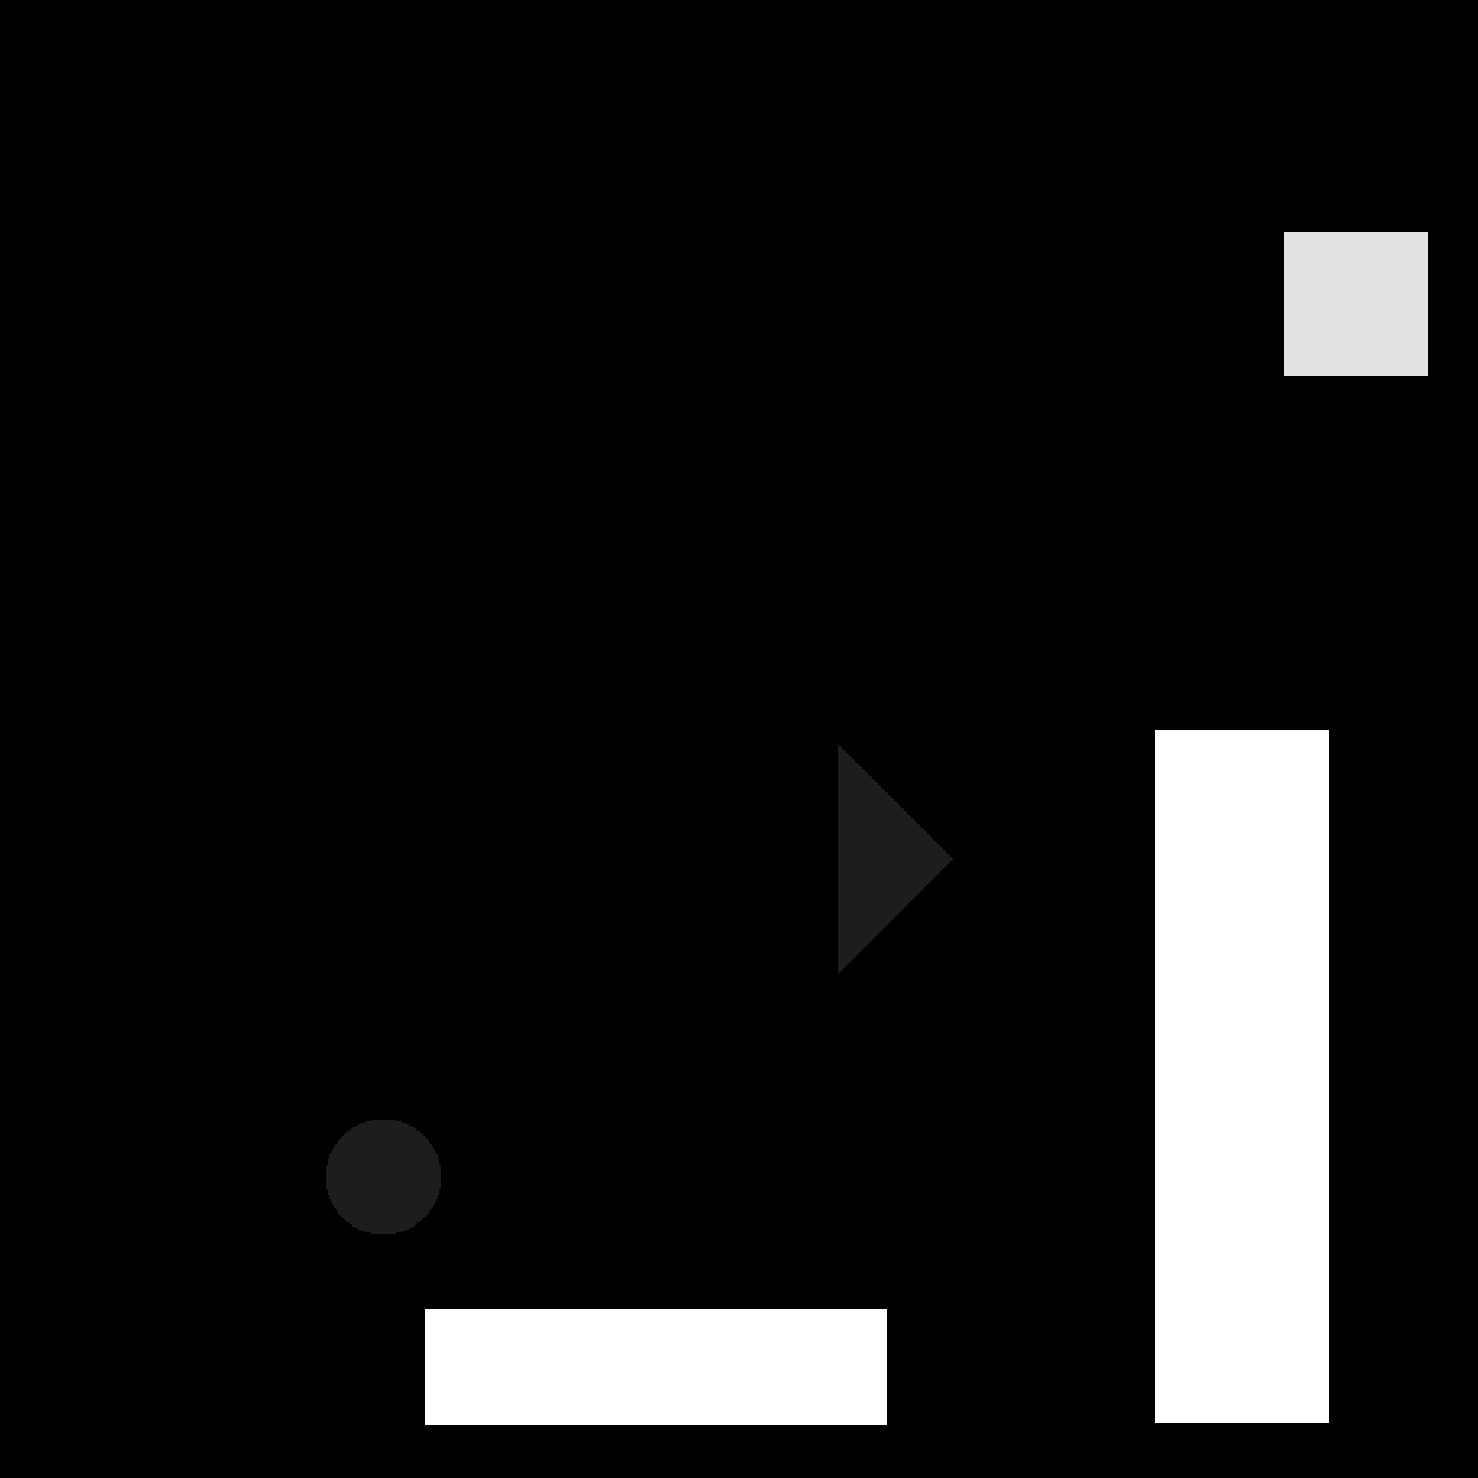

In [8]:
img_path = "../data/pos/images/train/0.png"
img = Image.open(img_path)
imgGray = img.convert('L')
imgGray

In [9]:
img_grey = preprocess(imgGray).unsqueeze(0)
z = model.visual.conv1(
        img_grey.type(model.visual.conv1.weight.dtype)
    )  # shape = [*, width, grid, grid]

# Second step: concatenate embeddings
z = z.reshape(z.shape[0], z.shape[1], -1)  # shape = [*, width, grid ** 2]
z = z.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

z = torch.cat(
    [
        model.visual.class_embedding.to(z.dtype)
        + torch.zeros(z.shape[0], 1, z.shape[-1], dtype=z.dtype, device=z.device),
        z,
    ],
    dim=1,
)  # shape = [*, grid ** 2 + 1, width]

In [10]:
print(orig_z.shape)
print(z.shape)

torch.Size([1, 50, 768])
torch.Size([1, 50, 768])


See below, the added class_embedding is not entirely the same for the grey-scale and colored image.

In [11]:
model.visual.class_embedding.shape

torch.Size([768])

In [12]:
epsilon = 1e-2

same_params_patch = {}
for patch in range(50):
    same_params_patch[patch] = 0
    for i in range(768):
        if torch.abs(orig_z[0][patch][i] - z[0][patch][i]) < epsilon:
            same_params_patch[patch] += 1

In [13]:
# for bb_patch in bb_patches.keys():
#     print(same_params_patch[bb_patch])

print(np.mean([same_params_patch[bb_patch] for bb_patch in bb_patches.keys()]))
print(np.mean([same_params_patch[key] for key in same_params_patch.keys()]))

561.7222222222222
663.76


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


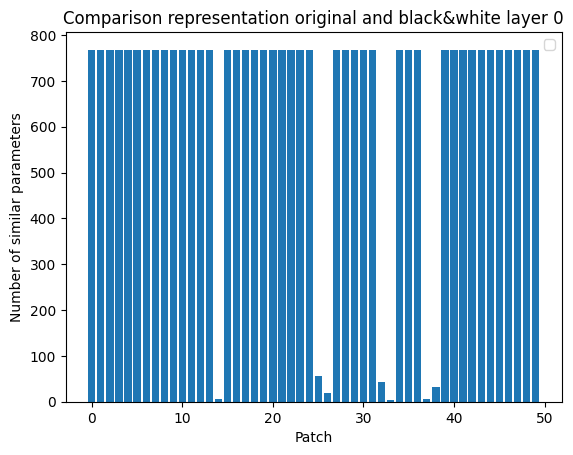

In [14]:
plt.bar(same_params_patch.keys(), same_params_patch.values())
# plt.bar([key for key in same_params_patch.keys() if key not in bb_patches.keys()], [same_params_patch[key] for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], color="green", label="no object")
plt.xlabel("Patch")
plt.ylabel("Number of similar parameters")
plt.title("Comparison representation original and black&white layer 0")
plt.legend()

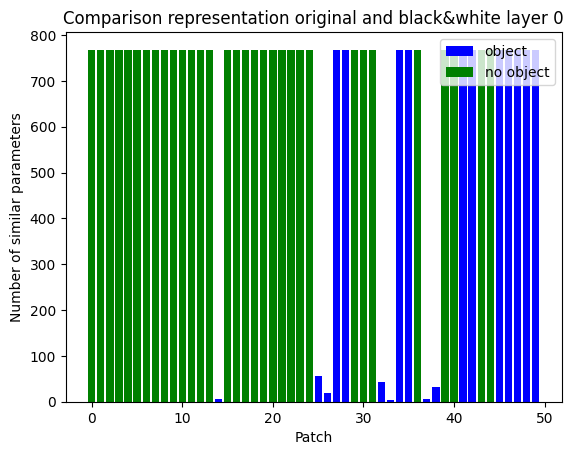

In [15]:
plt.bar([key+1 for key in bb_patches.keys()], [same_params_patch[bb_patch + 1] for bb_patch in bb_patches.keys()], color="blue", label="object")
plt.bar([key for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], [same_params_patch[key] for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], color="green", label="no object")
plt.xlabel("Patch")
plt.ylabel("Number of similar parameters")
plt.title("Comparison representation original and black&white layer 0")
plt.legend()

In [16]:
print([key for key in same_params_patch.keys() if key not in bb_patches.keys()])
# 0 not in bb_patches
# [key for key in same_params_patch.keys()]
bb_patches.keys()
13 not in bb_patches.keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 28, 29, 30, 35, 38, 39, 42, 43, 49]


False

In [17]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x180fcb820>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

I compare the first representations of an image and its black-and-white version. This first representation has been preprocessed, that includes: resizing, centercropping and normalization. Only the latter has a real influence on the images (that were already square to begin with). The normalization is a bit different for the black-and-white version, that's why the black patches are not entirely the same for both versions.

In the plot I plot the number of parameters per patch (out of 768) that is the same (plus or minus epsilon 1e-3) in both images. We see that the first patch (the positional embedding) is the most similar between the original and black&white image. Also, we see that the number of similar parameters is the lowest in the patches with objects.

Function below makes these plots for other images.

In [18]:
from transformer_patches import get_all_patches_with_objects

def plot_sim_img_origvsbw_layer0(img_name, dataset, split):
    epsilon = 1e-2

    img_id = img_name.replace(".png", "")
    orig_z = torch.from_numpy(reprs[img_id][layer])

    bb_patches = get_all_patches_with_objects(img_name, dataset, split)

    img_path = f"../data/{dataset}/images/{split}/{img_name}"
    img = Image.open(img_path)
    imgGray = img.convert('L')

    img_grey = preprocess(imgGray).unsqueeze(0)
    z = model.visual.conv1(
            img_grey.type(model.visual.conv1.weight.dtype)
        )  # shape = [*, width, grid, grid]

    # Second step: concatenate embeddings
    z = z.reshape(z.shape[0], z.shape[1], -1)  # shape = [*, width, grid ** 2]
    z = z.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

    z = torch.cat(
        [
            model.visual.class_embedding.to(z.dtype)
            + torch.zeros(z.shape[0], 1, z.shape[-1], dtype=z.dtype, device=z.device),
            z,
        ],
        dim=1,
    )  # shape = [*, grid ** 2 + 1, width]

    same_params_patch = {}
    for patch in range(50):
        same_params_patch[patch] = 0
        for i in range(768):
            if torch.abs(orig_z[0][patch][i] - z[0][patch][i]) < epsilon:
                same_params_patch[patch] += 1

    plt.bar([key+1 for key in bb_patches.keys()], [same_params_patch[bb_patch + 1] for bb_patch in bb_patches.keys()], color="blue", label="with object")
    plt.bar([key for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], [same_params_patch[key] for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], color="green", label="without object")
    plt.xlabel("Patch")
    plt.ylabel("Number of similar parameters")
    plt.xticks(np.arange(0, 49, 5))
    plt.title(f"Comparison original and black-and-white (layer 0, epsilon: {epsilon}, img_id: {img_name})")
    plt.legend()

../data/pos/images/train/1.png
(1478, 1478)


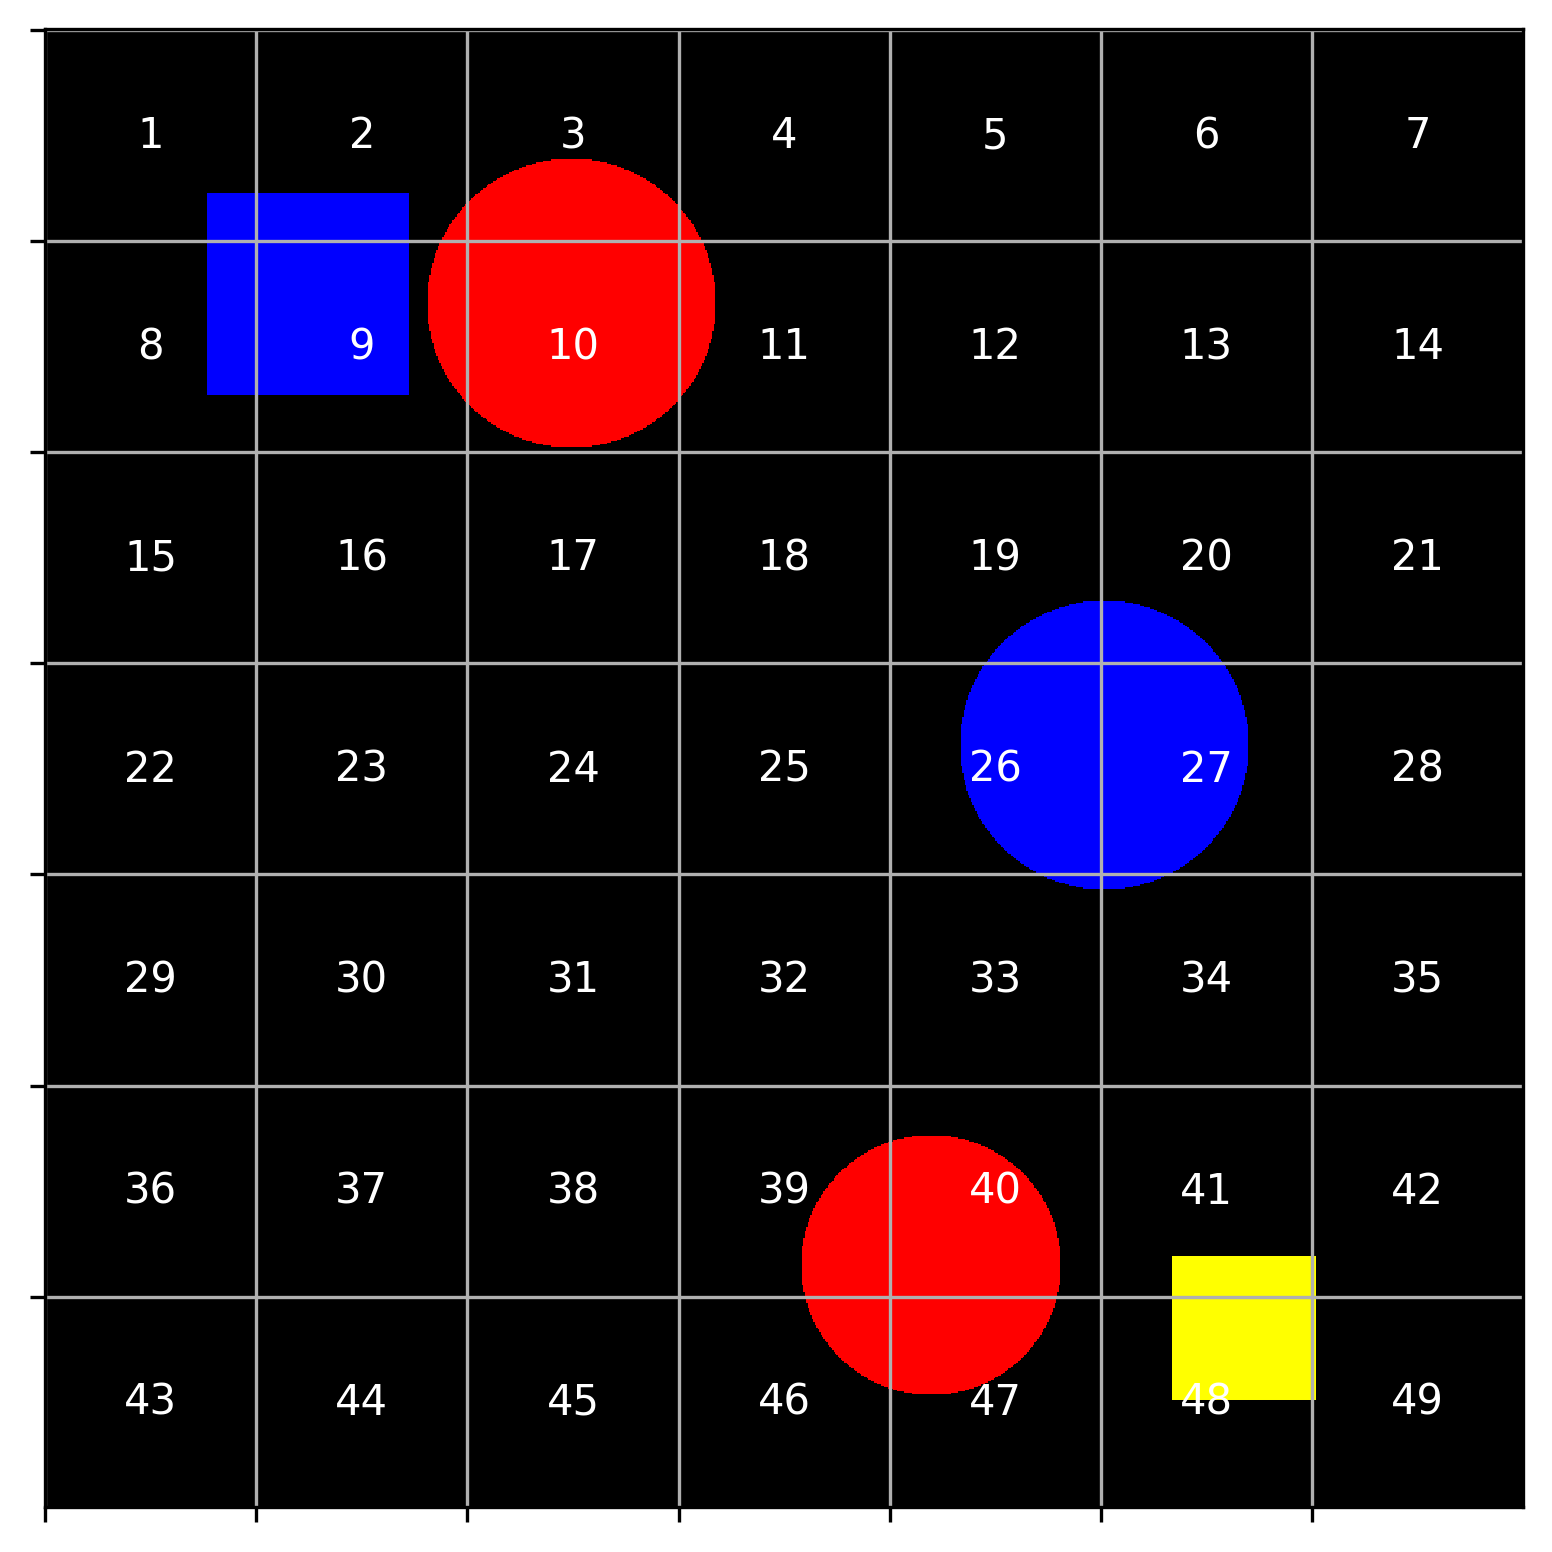

In [19]:
open_image_withpatches("1.png", "pos", "train", to_save=False)

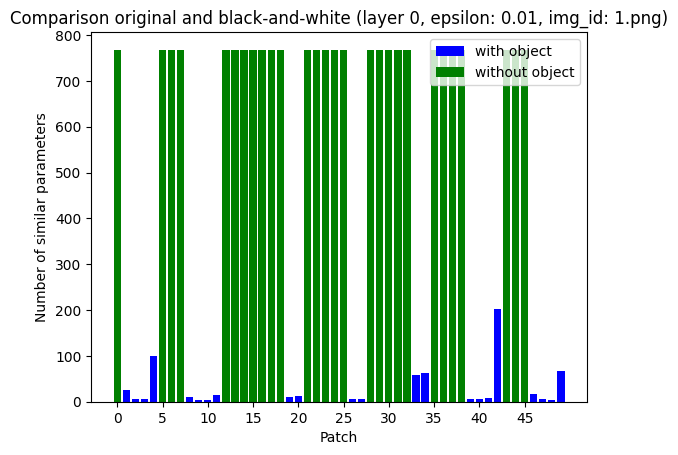

In [20]:
plot_sim_img_origvsbw_layer0("1.png", "pos", "train")

# Look at representations after kernelized color erasure

In [21]:
def get_projection_layer0(kernel_type, dataset, objective):
    if kernel_type == "poly":
        d = 1024
        gamma = 0.1
        degree = 2
        alpha = 1
    params_str = "kernel-type={}_d={}_gamma={}_degree={}_alpha={}".format(
            kernel_type, d, str(gamma), str(degree), str(alpha)
        )
    with open(
            f"../kernel_removal/{kernel_type}/{dataset}/{objective}/layer0/{params_str}/P.{params_str}.pickle",
            "rb",
        ) as f:
        projection = pickle.load(f)
    return projection

In [22]:
P = get_projection_layer0("poly", "pos", "color")

In [23]:
import run_kernels
from run_kernels import MLP

kernels = {
    "poly": {"torch": run_kernels.poly_kernel, "np": run_kernels.poly_kernel},
    "sigmoid": {"torch": run_kernels.sigmoid_kernel_torch, "np": run_kernels.sigmoid_kernel},
}

def get_kernelized_img_layer0(kernel_type, img_name, dataset, split):
    layer = 0
    if kernel_type == "poly":
        d = 1024
        gamma = 0.1
        degree = 2
        alpha = 1
    params_str = "kernel-type={}_d={}_gamma={}_degree={}_alpha={}".format(
        kernel_type, d, str(gamma), str(degree), str(alpha)
    )    
    # reprs_file = f"{dataset}_{split}_visual.pickle"
    # with open(f"../data/{dataset}/representations/" + reprs_file, "rb") as f:
    #     reprs = pickle.load(f)

    img_id = img_name.replace(".png", "")
    orig_z = reprs[img_id][layer].astype(np.float32)
    orig_z = np.squeeze(orig_z)
    orig_z = np.concatenate([orig_z, np.ones((orig_z.shape[0], 1))], axis=1)
    orig_z /= np.linalg.norm(orig_z, axis=1, keepdims=True)
    # print(orig_z.shape)
    # print(P.shape)

    # # Preperation: calculate Nystrom approximation with all data
    # X, Y, X_dev, Y_dev, X_test, Y_test = run_kernels.load_ViTpatches(
    #     dataset,
    #     "color",
    #     layer,
    #     threshold_patches=30,
    #     normalize=False,
    # )
    # X = X[:50000]
    # print(X.shape)
    # X = X.astype(np.float32)
    # X_kernel, S, X1 = run_kernels.calc_nystrom(X.copy(), d=d, kernel_func=kernels[kernel_type]["np"], alpha=alpha, gamma=gamma, degree=degree)
    # print("Found the nystrom approximation")

    # # 1. Project each patch into kernel space with Nystrom approximation
    # # X, S, _ = run_kernels.calc_nystrom(orig_z, d=d, kernel_func=kernels[kernel_type]["np"], alpha=alpha, gamma=gamma, degree=degree)
    # #TODO: Bit unclear still whether this is alright, is it valid to calculate the nystrom approximation with one image only? Or should I have stored the matrix S from before?
    # print("S.shape: ", S.shape)
    # print("orig_z.shape: ", orig_z.shape)
    # X = (
    #     kernels[kernel_type]["np"](
    #         orig_z, X1, gamma=gamma, degree=degree, alpha=alpha
    #     )
    #     @ S
    # )

    # print(X.shape)
    
    # # 2. Perform concept erasure in kernel space
    # X_proj = X @ P
    # print(X_proj.shape)

    # # 3. Calculate pre-image
    with open(f"../kernel_removal/{kernel_type}/{dataset}/color/layer{layer}/{params_str}/preimage/MLP.{params_str}.pickle", "rb") as f:
        mlp, _, _ = pickle.load(f)
    # X_final = (
    #     kernels[kernel_type]["torch"](
    #         mlp(torch.tensor(orig_z).to(torch.float32)), torch.tensor(X1), gamma=gamma, degree=degree, alpha=alpha
    #     )
    #     @ torch.tensor(S).float()
    # )
    # print(X_final.shape)
    X_final = mlp(torch.tensor(orig_z).to(torch.float32))

    return X_final

X_final = get_kernelized_img_layer0("poly", "1.png", "pos", "train")

In [24]:
X_final.shape

torch.Size([50, 769])

In [25]:
from run_kernels import MLP

params_str = "kernel-type=poly_d=1024_gamma=0.1_degree=2_alpha=1"  

with open(f"../kernel_removal/poly/pos/color/layer0/{params_str}/preimage/MLP.{params_str}.pickle", "rb") as f:
    mlp, _, _ = pickle.load(f)

# print("Size X_proj: ", X_proj.shape)
print(mlp)
orig_z = reprs[img_id][layer].astype(np.float32)
orig_z = np.squeeze(orig_z)
orig_z = np.concatenate([orig_z, np.ones((orig_z.shape[0], 1))], axis=1)
print(orig_z.shape)
mlp(torch.tensor(orig_z).to(torch.float32))

MLP(
  (lin1): Linear(in_features=769, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=769, bias=True)
  (lin4): Linear(in_features=769, out_features=769, bias=True)
  (BatchNorm1d_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BatchNorm1d_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BatchNorm1d_3): BatchNorm1d(301, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Dropout1d): Dropout(p=0.1, inplace=False)
  (W): Linear(in_features=769, out_features=769, bias=True)
)
(50, 769)


tensor([[ -1.9152,   0.2950,   0.7661,  ...,  -0.5199,  -0.9449,  -1.0288],
        [ -1.8429,  -0.9492,   3.7332,  ...,  -7.0752,   2.5793,   5.2558],
        [ -1.8429,  -0.9492,   3.7332,  ...,  -7.0752,   2.5793,   5.2558],
        ...,
        [-15.5872,  -9.5022,  19.6450,  ..., -37.9511,  27.9320,   4.5763],
        [  1.2466,  -9.3283,  28.4751,  ...,  18.4459,  13.2517, -21.8068],
        [  8.1313, -17.2566,  14.2630,  ..., -37.6780,  42.6324,  17.1867]],
       grad_fn=<AddBackward0>)

orig_z.shape:  torch.Size([50, 769])
kernel_z.shape:  torch.Size([50, 769])
dict_keys([0, 1, 2, 3, 7, 8, 9, 10, 18, 19, 25, 26, 32, 33, 38, 39, 40, 41, 45, 46, 47, 48])


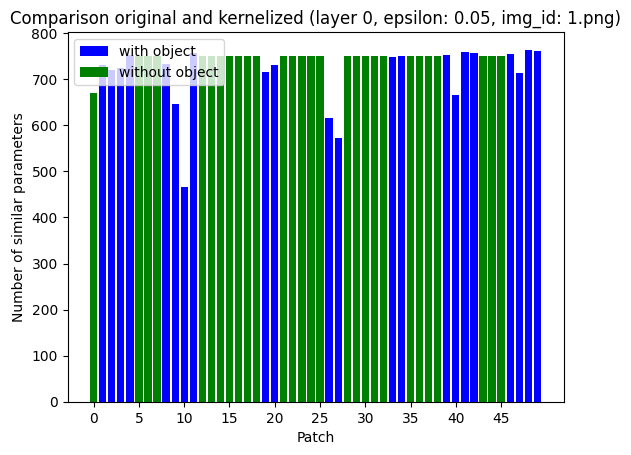

In [26]:
def plot_sim_img_origvskernelized_layer0(img_name, dataset, split):
    layer = 0
    epsilon = 5e-2

    img_id = img_name.replace(".png", "")
    orig_z = torch.from_numpy(reprs[img_id][layer])
    orig_z = torch.squeeze(orig_z)
    orig_z = torch.cat([orig_z, torch.ones((orig_z.shape[0], 1))], axis=1)

    # need to normalize the representations, because that's done too in kernelized concept erasure
    orig_z /= np.linalg.norm(orig_z, axis=1, keepdims=True)

    print("orig_z.shape: ", orig_z.shape)
    kernel_z = get_kernelized_img_layer0("poly", img_name, dataset, split)
    print("kernel_z.shape: ", kernel_z.shape)

    bb_patches = get_all_patches_with_objects(img_name, dataset, split)
    print(bb_patches.keys())

    same_params_patch = {}
    for patch in range(50):
        same_params_patch[patch] = 0
        for i in range(769):
            if torch.abs(orig_z[patch][i] - kernel_z[patch][i]) < epsilon:
                same_params_patch[patch] += 1

    plt.bar([key+1 for key in bb_patches.keys()], [same_params_patch[bb_patch + 1] for bb_patch in bb_patches.keys()], color="blue", label="with object")
    plt.bar([key for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], [same_params_patch[key] for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], color="green", label="without object")
    plt.xlabel("Patch")
    plt.ylabel("Number of similar parameters")
    plt.xticks(np.arange(0, 49, 5))
    plt.title(f"Comparison original and kernelized (layer 0, epsilon: {epsilon}, img_id: {img_name})")
    plt.legend()

plot_sim_img_origvskernelized_layer0("1.png", "pos", "train")

### Note that I stupidly concatenated ones to the representations, look into this!

## Sanity check getting kernelized representation

To check whether getting the kernelized representation properly works, I use the MLP to get X_preimage from X. 

In [27]:
# 1. Open the X_test_preimage

path = "../kernel_removal/poly/pos/color/layer0/kernel-type=poly_d=1024_gamma=0.1_degree=2_alpha=1/preimage/"
file_name = "Z_test.kernel-type=poly_d=1024_gamma=0.1_degree=2_alpha=1.pickle"

with open(path+file_name, "rb") as f:
    Z_test_preimage, _, _, _ = pickle.load(f)

In [28]:
# 2. Open the original X_test and use MLP to hopefully get the kernelized version

X, Y, X_dev, Y_dev, X_test, Y_test = run_kernels.load_ViTpatches(
    "pos",
    "color",
    layer=0,
    threshold_patches=30,
    normalize=True,
)

print(X_test.shape)
from run_kernels import MLP

params_str = "kernel-type=poly_d=1024_gamma=0.1_degree=2_alpha=1"  

with open(f"../kernel_removal/poly/pos/color/layer0/{params_str}/preimage/MLP.{params_str}.pickle", "rb") as f:
    mlp, _, _ = pickle.load(f)

# print("Size X_proj: ", X_proj.shape)
print(mlp)
# orig_z = reprs[img_id][layer].astype(np.float32)
# orig_z = np.squeeze(orig_z)
# orig_z = np.concatenate([orig_z, np.ones((orig_z.shape[0], 1))], axis=1)
# print(orig_z.shape)
Z_test_mlp = mlp(torch.tensor(X_test).to(torch.float32))
# mlp(torch.tensor(orig_z).to(torch.float32))

Started with loading ViT patches in split: train
Started with loading ViT patches in split: val
Started with loading ViT patches in split: test
(35437, 768)
MLP(
  (lin1): Linear(in_features=769, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=769, bias=True)
  (lin4): Linear(in_features=769, out_features=769, bias=True)
  (BatchNorm1d_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BatchNorm1d_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BatchNorm1d_3): BatchNorm1d(301, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Dropout1d): Dropout(p=0.1, inplace=False)
  (W): Linear(in_features=769, out_features=769, bias=True)
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (35437x768 and 769x512)

In [29]:
# 3. Compare the two X_test_preimages
from tqdm import tqdm

Z_test_preimage = torch.tensor(Z_test_preimage).to(torch.float32)

print(Z_test_preimage.shape)
print(Z_test_mlp.shape)

print(Z_test_preimage[0][0].item())
print(Z_test_mlp[0][0].item())

epsilon = 1e-5
same_params_patch = []
for patch in tqdm(range(5000)):
    count = 0
    for i in range(769):
        if torch.abs(Z_test_preimage[patch][i] - Z_test_mlp[patch][i]) < epsilon:
            count += 1
    same_params_patch.append(count)

# print(torch.allclose(Z_test_mlp, Z_test_preimage))

print(np.mean(same_params_patch))

# print(torch.eq(Z_test_preimage[0][0], Z_test_mlp[0][0]))
# print(Z_test_preimage[0][0].item() == Z_test_mlp[0][0].item())

# torch.eq(Z_test_mlp, Z_test_preimage)

torch.Size([35437, 769])


NameError: name 'Z_test_mlp' is not defined

Sanity check passed, but found two interesting properties:
1. I should normalize the representations to use the MLP for kernelization, because this is how the original MLP was trained.
2. I should concatenate a column of 1's to the patches, because that was done originally too.
In v2, I retrained the kernel concept erasure without these two specifics.

## v2 kernelized concept erasure
Color

In [30]:
import run_kernels
from run_kernels import MLP

kernels = {
    "poly": {"torch": run_kernels.poly_kernel, "np": run_kernels.poly_kernel},
    "sigmoid": {"torch": run_kernels.sigmoid_kernel_torch, "np": run_kernels.sigmoid_kernel},
}

def get_kernelized_img_layer0(kernel_type, img_name, dataset, split):
    layer = 0
    if kernel_type == "poly":
        d = 1024
        gamma = 0.1
        degree = 2
        alpha = 1
    params_str = "kernel-type={}_d={}_gamma={}_degree={}_alpha={}".format(
        kernel_type, d, str(gamma), str(degree), str(alpha)
    )    
    # reprs_file = f"{dataset}_{split}_visual.pickle"
    # with open(f"../data/{dataset}/representations/" + reprs_file, "rb") as f:
    #     reprs = pickle.load(f)

    img_id = img_name.replace(".png", "")
    orig_z = reprs[img_id][layer].astype(np.float32)
    orig_z = np.squeeze(orig_z)

    # 3. Calculate pre-image
    with open(f"../kernel_removal/{kernel_type}/{dataset}/color/layer{layer}/v2/{params_str}/preimage/MLP.{params_str}.pickle", "rb") as f:
        mlp, _, _ = pickle.load(f)
    X_final = mlp(torch.tensor(orig_z).to(torch.float32))

    return X_final

X_final = get_kernelized_img_layer0("poly", "1.png", "pos", "train")

orig_z.shape:  torch.Size([50, 768])
kernel_z.shape:  torch.Size([50, 768])
dict_keys([0, 1, 2, 3, 7, 8, 9, 10, 18, 19, 25, 26, 32, 33, 38, 39, 40, 41, 45, 46, 47, 48])


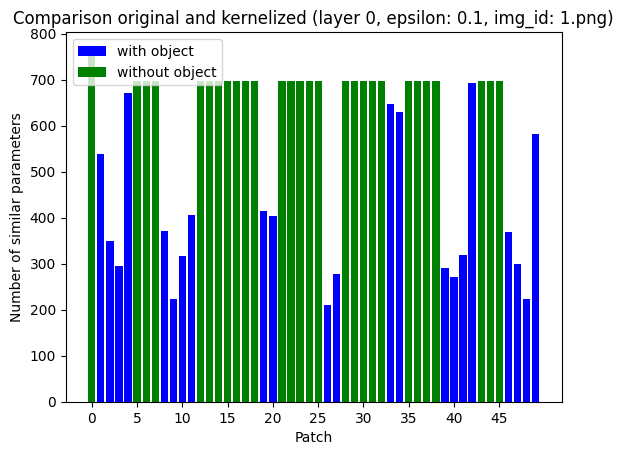

In [31]:
def plot_sim_img_origvskernelized_layer0(img_name, dataset, split):
    layer = 0
    epsilon = 1e-1

    img_id = img_name.replace(".png", "")
    orig_z = torch.from_numpy(reprs[img_id][layer])
    orig_z = torch.squeeze(orig_z)
    # orig_z = torch.cat([orig_z, torch.ones((orig_z.shape[0], 1))], axis=1)

    # need to normalize the representations, because that's done too in kernelized concept erasure
    # orig_z /= np.linalg.norm(orig_z, axis=1, keepdims=True)

    print("orig_z.shape: ", orig_z.shape)
    kernel_z = get_kernelized_img_layer0("poly", img_name, dataset, split)
    print("kernel_z.shape: ", kernel_z.shape)

    bb_patches = get_all_patches_with_objects(img_name, dataset, split)
    print(bb_patches.keys())

    same_params_patch = {}
    for patch in range(50):
        same_params_patch[patch] = 0
        for i in range(768):
            if torch.abs(orig_z[patch][i] - kernel_z[patch][i]) < epsilon:
                same_params_patch[patch] += 1

    plt.bar([key+1 for key in bb_patches.keys()], [same_params_patch[bb_patch + 1] for bb_patch in bb_patches.keys()], color="blue", label="with object")
    plt.bar([key for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], [same_params_patch[key] for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], color="green", label="without object")
    plt.xlabel("Patch")
    plt.ylabel("Number of similar parameters")
    plt.xticks(np.arange(0, 49, 5))
    plt.title(f"Comparison original and kernelized (layer 0, epsilon: {epsilon}, img_id: {img_name})")
    plt.legend()

plot_sim_img_origvskernelized_layer0("1.png", "pos", "train")

From the image above, we see that the first patch is unaffected for this epsilon under kernelization, and the patches without objects are all the same. Patches with objects change more under kernelization: the number of similar parameters drastically decreases. We see that patches with more objects change more. 

## Difference kernelization and black-and-white images

dict_keys([0, 1, 2, 3, 7, 8, 9, 10, 18, 19, 25, 26, 32, 33, 38, 39, 40, 41, 45, 46, 47, 48])
kernel_z.shape:  torch.Size([50, 768])
bw_z.shape:  torch.Size([1, 50, 768])


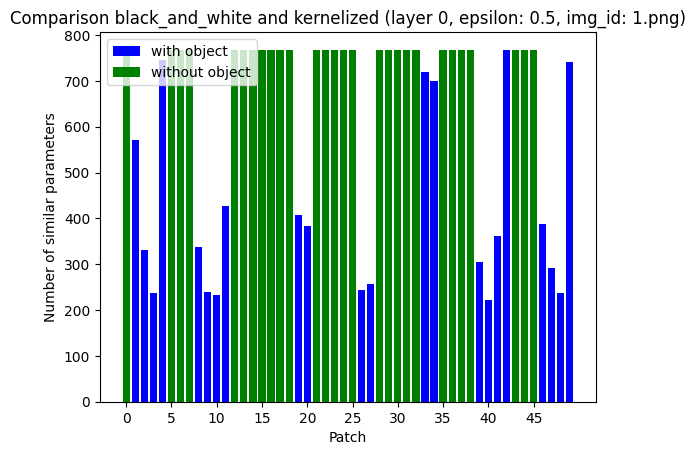

In [32]:
def plot_sim_img_bwvskernelized_layer0(img_name, dataset, split):
    layer = 0
    epsilon = 5e-1

    bb_patches = get_all_patches_with_objects(img_name, dataset, split)
    print(bb_patches.keys())

    # 1. Get kernelized version
    img_id = img_name.replace(".png", "")
    orig_z = torch.from_numpy(reprs[img_id][layer])
    orig_z = torch.squeeze(orig_z)
    kernel_z = get_kernelized_img_layer0("poly", img_name, dataset, split)

    print("kernel_z.shape: ", kernel_z.shape)

    # 2. Get black-and-white representation
    img_path = f"../data/{dataset}/images/{split}/{img_name}"
    img = Image.open(img_path)
    imgGray = img.convert('L')

    img_grey = preprocess(imgGray).unsqueeze(0)
    z = model.visual.conv1(
            img_grey.type(model.visual.conv1.weight.dtype)
        )  # shape = [*, width, grid, grid]

    # Second step: concatenate embeddings
    z = z.reshape(z.shape[0], z.shape[1], -1)  # shape = [*, width, grid ** 2]
    z = z.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

    bw_z = torch.cat(
        [
            model.visual.class_embedding.to(z.dtype)
            + torch.zeros(z.shape[0], 1, z.shape[-1], dtype=z.dtype, device=z.device),
            z,
        ],
        dim=1,
    )  # shape = [*, grid ** 2 + 1, width]
    print("bw_z.shape: ", bw_z.shape)


    same_params_patch = {}
    for patch in range(50):
        same_params_patch[patch] = 0
        for i in range(768):
            if torch.abs(bw_z[0][patch][i] - kernel_z[patch][i]) < epsilon:
                same_params_patch[patch] += 1

    plt.bar([key+1 for key in bb_patches.keys()], [same_params_patch[bb_patch + 1] for bb_patch in bb_patches.keys()], color="blue", label="with object")
    plt.bar([key for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], [same_params_patch[key] for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], color="green", label="without object")
    plt.xlabel("Patch")
    plt.ylabel("Number of similar parameters")
    plt.xticks(np.arange(0, 49, 5))
    plt.title(f"Comparison black_and_white and kernelized (layer 0, epsilon: {epsilon}, img_id: {img_name})")
    plt.legend()

plot_sim_img_bwvskernelized_layer0("1.png", "pos", "train")

From this plot, we see that kernelization does something else than making the image black-and-white, because the object patches are still different. Maybe now look at cosine similarity.

dict_keys([0, 1, 2, 3, 7, 8, 9, 10, 18, 19, 25, 26, 32, 33, 38, 39, 40, 41, 45, 46, 47, 48])
kernel_z.shape:  torch.Size([50, 768])
bw_z.shape:  torch.Size([1, 50, 768])


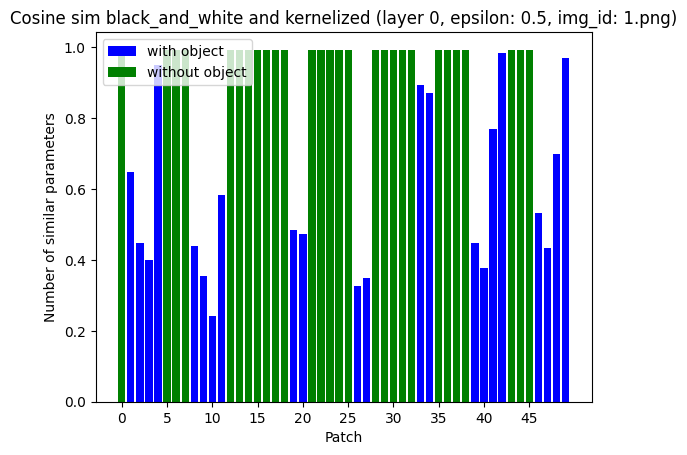

In [33]:
def plot_cossim_img_bwvskernelized_layer0(img_name, dataset, split):
    layer = 0
    epsilon = 5e-1

    bb_patches = get_all_patches_with_objects(img_name, dataset, split)
    print(bb_patches.keys())

    # 1. Get kernelized version
    img_id = img_name.replace(".png", "")
    orig_z = torch.from_numpy(reprs[img_id][layer])
    orig_z = torch.squeeze(orig_z)
    kernel_z = get_kernelized_img_layer0("poly", img_name, dataset, split)

    print("kernel_z.shape: ", kernel_z.shape)

    # 2. Get black-and-white representation
    img_path = f"../data/{dataset}/images/{split}/{img_name}"
    img = Image.open(img_path)
    imgGray = img.convert('L')

    img_grey = preprocess(imgGray).unsqueeze(0)
    z = model.visual.conv1(
            img_grey.type(model.visual.conv1.weight.dtype)
        )  # shape = [*, width, grid, grid]

    # Second step: concatenate embeddings
    z = z.reshape(z.shape[0], z.shape[1], -1)  # shape = [*, width, grid ** 2]
    z = z.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

    bw_z = torch.cat(
        [
            model.visual.class_embedding.to(z.dtype)
            + torch.zeros(z.shape[0], 1, z.shape[-1], dtype=z.dtype, device=z.device),
            z,
        ],
        dim=1,
    )  # shape = [*, grid ** 2 + 1, width]
    print("bw_z.shape: ", bw_z.shape)


    same_params_patch = {}
    for patch in range(50):
        a = kernel_z[patch].detach().numpy()
        b = bw_z[0][patch].detach().numpy()
        cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
        same_params_patch[patch] = cos_sim

    plt.bar([key+1 for key in bb_patches.keys()], [same_params_patch[bb_patch + 1] for bb_patch in bb_patches.keys()], color="blue", label="with object")
    plt.bar([key for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], [same_params_patch[key] for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], color="green", label="without object")
    plt.xlabel("Patch")
    plt.ylabel("Number of similar parameters")
    plt.xticks(np.arange(0, 49, 5))
    plt.title(f"Cosine sim black_and_white and kernelized (layer 0, epsilon: {epsilon}, img_id: {img_name})")
    plt.legend()

plot_cossim_img_bwvskernelized_layer0("1.png", "pos", "train")

From this plot, it looks like the more color on a patch, the more its representations changes when kernelizing. The representations change more if more color was present on the patch.

Next question; what does a preprocessed image looks like? What does a preprocessed patch look like? I want to know what the MLP really does to the image...

## What does the MLP do?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x180fcb820>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


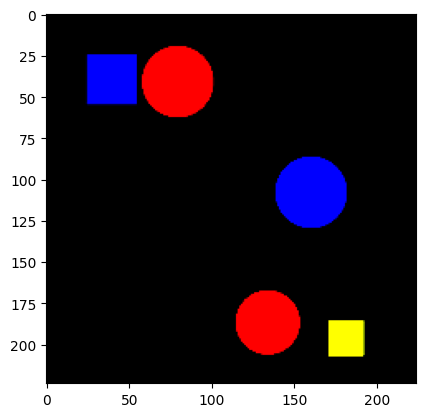

In [34]:
img_path = f"../data/pos/images/train/1.png"
img = Image.open(img_path)
img = preprocess(img)

print(preprocess)
plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x180fcb820>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


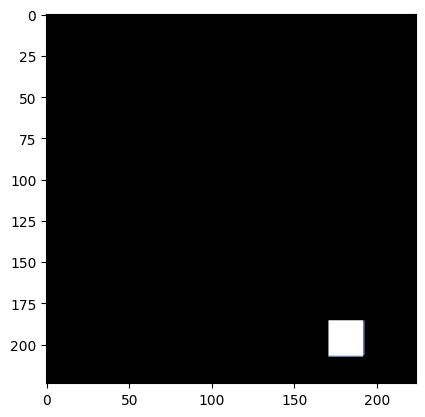

In [71]:
img_path = f"../data/pos/images/train/1.png"
img = Image.open(img_path)
img = img.convert('L')
img.show()
# print(img.shape)
# img.show()
# print(img)
# plt.imshow(img)
img
img = preprocess(img)
# img
print(preprocess)
plt.imshow(img.permute(1, 2, 0))

In [36]:
model.visual.conv1.weight

Parameter containing:
tensor([[[[ 5.0812e-03,  6.1703e-04,  6.2847e-04,  ..., -1.0490e-03,
           -1.3018e-03,  4.1962e-03],
          [ 1.1520e-02,  4.1428e-03, -1.2531e-03,  ..., -3.4199e-03,
           -5.4026e-04,  5.6000e-03],
          [ 1.1536e-02,  3.4070e-04, -6.4240e-03,  ..., -2.3956e-03,
            2.4281e-03,  6.1913e-03],
          ...,
          [ 2.5673e-03, -8.7261e-04, -1.0391e-02,  ..., -5.8517e-03,
           -7.8022e-05, -2.8591e-03],
          [ 3.0994e-04, -4.1847e-03, -9.4299e-03,  ..., -4.8981e-03,
            5.1737e-04, -1.2999e-03],
          [ 1.3380e-03,  1.3447e-03, -3.0231e-04,  ...,  2.0618e-03,
            2.9469e-03,  1.8911e-03]],

         [[ 1.0090e-03, -4.2915e-03, -3.1261e-03,  ..., -1.9274e-03,
           -3.1052e-03,  2.1687e-03],
          [ 5.8098e-03, -3.3245e-03, -7.1411e-03,  ..., -6.5269e-03,
           -9.7942e-04,  3.1776e-03],
          [ 3.5515e-03, -9.3842e-03, -1.5701e-02,  ..., -5.7678e-03,
            9.9468e-04,  2.7351e-03]

In [37]:
img_path = f"../data/pos/images/train/1.png"
img = Image.open(img_path)
img = preprocess(img).unsqueeze(0)

# print(preprocess)
# plt.imshow(img.permute(1, 2, 0))

z = model.visual.conv1(
    img.type(model.visual.conv1.weight.dtype)
)
z = z.reshape(z.shape[0], z.shape[1], -1)
z = torch.squeeze(z)

print(z.shape)

torch.Size([768, 49])


From here, it looks like blue and red colors disappear. This does not help me much further. I will look into how localized the information is.

## How localized is the information in representation?

First, check if all the black patches are equal to each other. That is the case. Note that the first patch is the class embedding, and is different from the others. 

In [59]:
img_name = "1.png"
dataset= "pos"
split = "train"

img_id = img_name.replace(".png", "")
orig_z = torch.from_numpy(reprs[img_id][layer])
orig_z = torch.squeeze(orig_z).T
print(orig_z.shape)
bb_patches = get_all_patches_with_objects(img_name, dataset, split)
black_patches = [orig_z[:, key] for key in range(50) if key-1 not in bb_patches.keys()]

print(len(black_patches))
# print(black_patches[0])
# print(black_patches[1])

for i in range(2, len(black_patches)):
    # print(black_patches[i].shape)
    print(torch.equal(black_patches[1], black_patches[i]))


torch.Size([768, 50])
28
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


max:  tensor(13.2812, dtype=torch.float16)
min:  tensor(-15.2344, dtype=torch.float16)
torch.Size([50, 768])
28
(768,)
(768, 28)


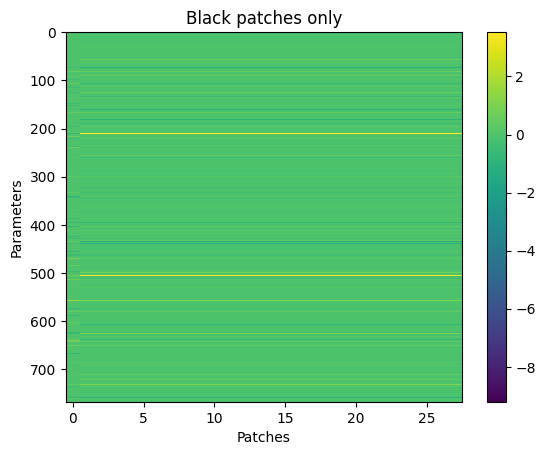

In [63]:
def plot_representations_layer0(img_name, dataset, split, subset=None):
    layer = 0
    # epsilon = 1e-1

    # 1. Get original representation
    img_id = img_name.replace(".png", "")
    orig_z = torch.from_numpy(reprs[img_id][layer])
    orig_z = torch.squeeze(orig_z)
    print("max: ", torch.max(orig_z))
    print("min: ", torch.min(orig_z))
    print(orig_z.shape)

    if subset is not None:
        bb_patches = get_all_patches_with_objects(img_name, dataset, split)
        orig_z = orig_z.T.detach().numpy()
        if subset == "no_objects":
            difference_patches = [orig_z[:, key] for key in range(50) if key-1 not in bb_patches.keys()]
            plt.title("Black patches only")
        elif subset == "only_objects":
            difference_patches = [orig_z[:, i+1] for i in bb_patches.keys()]
            plt.title("Only object patches")
        print(len(difference_patches))
        print(difference_patches[0].shape)
        difference_patches = np.asarray(difference_patches).T
        print(difference_patches.shape)
        plt.imshow(difference_patches, interpolation='nearest', aspect="auto")
    else:
        plt.imshow(orig_z.T[:, :15], interpolation='nearest', aspect="auto")
        plt.title("First 15 patches")

    plt.colorbar()
    plt.xlabel("Patches")
    plt.ylabel("Parameters")
    plt.show()


plot_representations_layer0("1.png", "pos", "train", subset="no_objects")

### What does a kernelized representation look like?

22
(768,)
(768, 22)


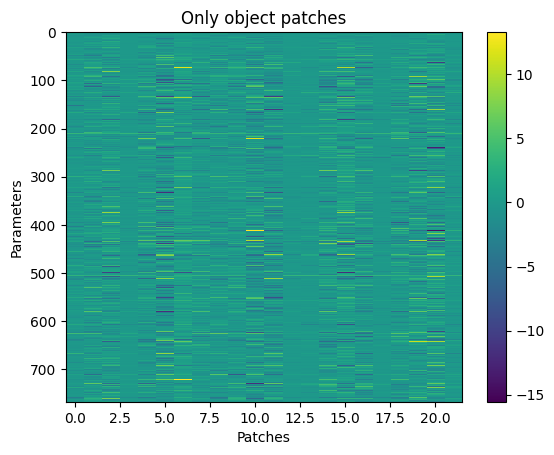

In [69]:
def plot_kernelized_representations_layer0(img_name, dataset, split, subset=None):
    layer = 0
    # epsilon = 1e-1

    kernel_z = get_kernelized_img_layer0("poly", img_name, dataset, split)

    if subset is not None:
        bb_patches = get_all_patches_with_objects(img_name, dataset, split)
        kernel_z = kernel_z.T.detach().numpy()
        if subset == "no_objects":
            difference_patches = [kernel_z[:, key] for key in range(50) if key-1 not in bb_patches.keys()]
            plt.title("Black patches only")
        elif subset == "only_objects":
            difference_patches = [kernel_z[:, i+1] for i in bb_patches.keys()]
            plt.title("Only object patches")
        print(len(difference_patches))
        print(difference_patches[0].shape)
        difference_patches = np.asarray(difference_patches).T
        print(difference_patches.shape)
        plt.imshow(difference_patches, interpolation='nearest', aspect="auto")
    else:
        plt.imshow(kernel_z.T[:, :15], interpolation='nearest', aspect="auto")
        plt.title("First 15 patches")

    plt.colorbar()
    plt.xlabel("Patches")
    plt.ylabel("Parameters")
    plt.show()


plot_kernelized_representations_layer0("1.png", "pos", "train", subset="only_objects")

### Now, what changes in the representations when they are kernelized?

orig_z.shape:  torch.Size([50, 768])
kernel_z.shape:  torch.Size([50, 768])
dict_keys([0, 1, 2, 3, 7, 8, 9, 10, 18, 19, 25, 26, 32, 33, 38, 39, 40, 41, 45, 46, 47, 48])
torch.Size([50, 768])
(768, 50)


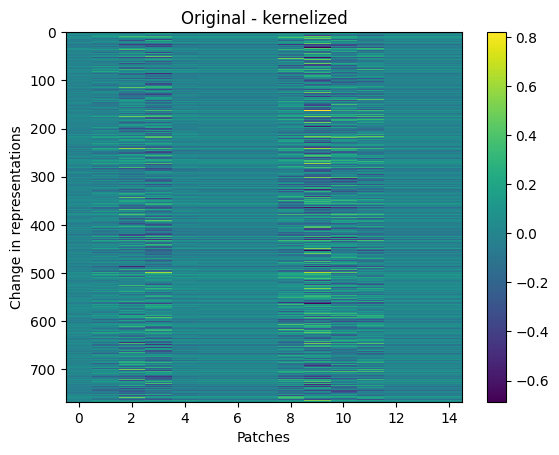

In [64]:
def plot_localize_origvskernelized_layer0(img_name, dataset, split):
    layer = 0
    # epsilon = 1e-1

    img_id = img_name.replace(".png", "")
    orig_z = torch.from_numpy(reprs[img_id][layer])
    orig_z = torch.squeeze(orig_z)
    # orig_z = torch.cat([orig_z, torch.ones((orig_z.shape[0], 1))], axis=1)

    # need to normalize the representations, because that's done too in kernelized concept erasure
    # orig_z /= np.linalg.norm(orig_z, axis=1, keepdims=True)

    print("orig_z.shape: ", orig_z.shape)
    kernel_z = get_kernelized_img_layer0("poly", img_name, dataset, split)
    print("kernel_z.shape: ", kernel_z.shape)

    bb_patches = get_all_patches_with_objects(img_name, dataset, split)
    print(bb_patches.keys())

    # diff_params_patch = {}
    # for patch in range(50):
    #     diff_params_zpatch = orig_z[patch] - kernel_z[patch]
    #     print(diff_params_patch)

    # plt.subplot(211)
    print(kernel_z.shape)
    difference = orig_z.T.detach().numpy()-kernel_z.T.detach().numpy()
    print(difference.shape)
    plt.imshow(difference[:,:15], interpolation='nearest', aspect="auto")
    # plt.subplot(212)
    # plt.imshow(np.random.random((100, 100)))

    # plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    # cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    # plt.colorbar(cax=cax)
    plt.colorbar()
    plt.xlabel("Patches")
    plt.ylabel("Change in representations")
    plt.title("Original - kernelized")
    plt.show()

    # plt.bar([key+1 for key in bb_patches.keys()], [same_params_patch[bb_patch + 1] for bb_patch in bb_patches.keys()], color="blue", label="with object")
    # plt.bar([key for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], [same_params_patch[key] for key in same_params_patch.keys() if key-1 not in bb_patches.keys()], color="green", label="without object")
    # plt.xlabel("Patch")
    # plt.ylabel("Number of similar parameters")
    # plt.xticks(np.arange(0, 49, 5))
    # plt.title(f"Comparison original and kernelized (layer 0, epsilon: {epsilon}, img_id: {img_name})")
    # plt.legend()

plot_localize_origvskernelized_layer0("1.png", "pos", "train")

(768, 50)


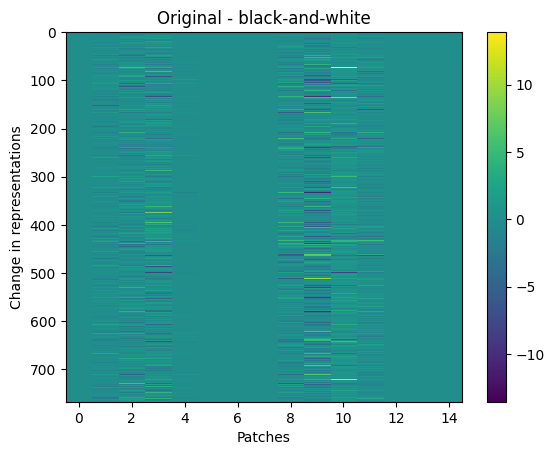

In [70]:
def plot_localize_origvsblackwhite_layer0(img_name, dataset, split):
    layer = 0
    # epsilon = 1e-1

    # 1. Get original representation
    img_id = img_name.replace(".png", "")
    orig_z = torch.from_numpy(reprs[img_id][layer])
    orig_z = torch.squeeze(orig_z)
    
    # 2. Get black and white representation
    img_path = f"../data/{dataset}/images/{split}/{img_name}"
    img = Image.open(img_path)
    imgGray = img.convert('L')

    img_grey = preprocess(imgGray).unsqueeze(0)
    z = model.visual.conv1(
            img_grey.type(model.visual.conv1.weight.dtype)
        )  # shape = [*, width, grid, grid]

    # Second step: concatenate embeddings
    z = z.reshape(z.shape[0], z.shape[1], -1)  # shape = [*, width, grid ** 2]
    z = z.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

    bw_z = torch.cat(
        [
            model.visual.class_embedding.to(z.dtype)
            + torch.zeros(z.shape[0], 1, z.shape[-1], dtype=z.dtype, device=z.device),
            z,
        ],
        dim=1,
    )  # shape = [*, grid ** 2 + 1, width]\
    bw_z = torch.squeeze(bw_z)

    # bb_patches = get_all_patches_with_objects(img_name, dataset, split)
    # print(bb_patches.keys())

    # diff_params_patch = {}
    # for patch in range(50):
    #     diff_params_patch = orig_z[patch] - kernel_z[patch]
    #     print(diff_params_patch)

    # plt.subplot(211)
    difference = orig_z.T.detach().numpy()-bw_z.T.detach().numpy()
    print(difference.shape)
    plt.imshow(difference[:,:15], interpolation='nearest', aspect="auto")
    # plt.subplot(212)
    # plt.imshow(np.random.random((100, 100)))

    # plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    # cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    # plt.colorbar(cax=cax)
    plt.colorbar()
    plt.xlabel("Patches")
    plt.ylabel("Change in representations")
    plt.title("Original - black-and-white")
    plt.show()

plot_localize_origvsblackwhite_layer0("1.png", "pos", "train")

(768, 50)
(768, 22)


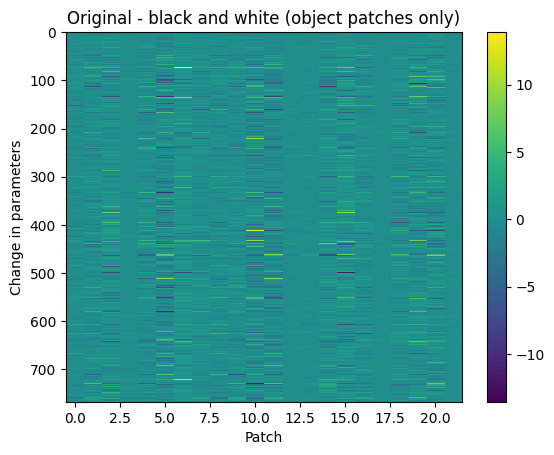

In [ ]:
def plot_localize_origvsblackwhite_layer0(img_name, dataset, split):
    layer = 0
    # epsilon = 1e-1

    # 1. Get original representation
    img_id = img_name.replace(".png", "")
    orig_z = torch.from_numpy(reprs[img_id][layer])
    orig_z = torch.squeeze(orig_z)
    
    # 2. Get black and white representation
    img_path = f"../data/{dataset}/images/{split}/{img_name}"
    img = Image.open(img_path)
    imgGray = img.convert('L')

    img_grey = preprocess(imgGray).unsqueeze(0)
    z = model.visual.conv1(
            img_grey.type(model.visual.conv1.weight.dtype)
        )  # shape = [*, width, grid, grid]

    # Second step: concatenate embeddings
    z = z.reshape(z.shape[0], z.shape[1], -1)  # shape = [*, width, grid ** 2]
    z = z.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

    bw_z = torch.cat(
        [
            model.visual.class_embedding.to(z.dtype)
            + torch.zeros(z.shape[0], 1, z.shape[-1], dtype=z.dtype, device=z.device),
            z,
        ],
        dim=1,
    )  # shape = [*, grid ** 2 + 1, width]\
    bw_z = torch.squeeze(bw_z)

    bb_patches = get_all_patches_with_objects(img_name, dataset, split)
    # print(bb_patches.keys())

    # diff_params_patch = {}
    # for patch in range(50):
    #     diff_params_patch = orig_z[patch] - kernel_z[patch]
    #     print(diff_params_patch)

    # plt.subplot(211)
    difference = orig_z.T.detach().numpy()-bw_z.T.detach().numpy()
    print(difference.shape)

    difference_patches = [difference[:, i+1] for i in bb_patches.keys()]
    difference_patches = np.asarray(difference_patches).T
    # print(len(difference_patches))
    print(difference_patches.shape)
    # plt.imshow([difference[:, i] for i in bb_patches.keys()], interpolation="nereast", aspect="auto")

    plt.imshow(difference_patches, interpolation='nearest', aspect="auto")
    # plt.subplot(212)
    # plt.imshow(np.random.random((100, 100)))

    # plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    # cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    # plt.colorbar(cax=cax)
    plt.colorbar()
    plt.xlabel("Patch")
    plt.ylabel("Change in parameters")
    plt.title("Original - black and white (object patches only)")
    plt.show()

plot_localize_origvsblackwhite_layer0("1.png", "pos", "train")

(768, 50)
(768, 28)


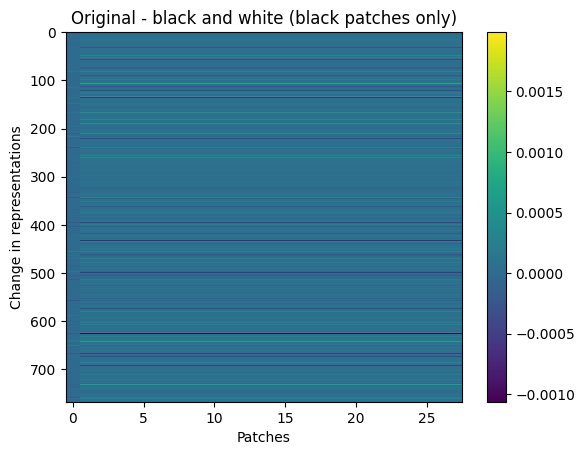

In [ ]:
def plot_localize_origvsblackwhite_layer0(img_name, dataset, split):
    layer = 0
    # epsilon = 1e-1

    # 1. Get original representation
    img_id = img_name.replace(".png", "")
    orig_z = torch.from_numpy(reprs[img_id][layer])
    orig_z = torch.squeeze(orig_z)
    
    # 2. Get black and white representation
    img_path = f"../data/{dataset}/images/{split}/{img_name}"
    img = Image.open(img_path)
    imgGray = img.convert('L')

    img_grey = preprocess(imgGray).unsqueeze(0)
    z = model.visual.conv1(
            img_grey.type(model.visual.conv1.weight.dtype)
        )  # shape = [*, width, grid, grid]

    # Second step: concatenate embeddings
    z = z.reshape(z.shape[0], z.shape[1], -1)  # shape = [*, width, grid ** 2]
    z = z.permute(0, 2, 1)  # shape = [*, grid ** 2, width]

    bw_z = torch.cat(
        [
            model.visual.class_embedding.to(z.dtype)
            + torch.zeros(z.shape[0], 1, z.shape[-1], dtype=z.dtype, device=z.device),
            z,
        ],
        dim=1,
    )  # shape = [*, grid ** 2 + 1, width]\
    bw_z = torch.squeeze(bw_z)

    bb_patches = get_all_patches_with_objects(img_name, dataset, split)
    # print(bb_patches.keys())

    # diff_params_patch = {}
    # for patch in range(50):
    #     diff_params_patch = orig_z[patch] - kernel_z[patch]
    #     print(diff_params_patch)

    # plt.subplot(211)
    difference = orig_z.T.detach().numpy()-bw_z.T.detach().numpy()
    print(difference.shape)

    difference_patches = [difference[:, key] for key in range(50) if key-1 not in bb_patches.keys()]
    # key for key in same_params_patch.keys() if key-1 not in bb_patches.keys()]
    difference_patches = np.asarray(difference_patches).T
    # print(len(difference_patches))
    print(difference_patches.shape)
    # plt.imshow([difference[:, i] for i in bb_patches.keys()], interpolation="nereast", aspect="auto")

    plt.imshow(difference_patches, interpolation='nearest', aspect="auto")
    # plt.subplot(212)
    # plt.imshow(np.random.random((100, 100)))

    # plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    # cax = plt.axes([0.85, 0.1, 0.075, 0.8])
    # plt.colorbar(cax=cax)
    plt.colorbar()
    plt.xlabel("Patches")
    plt.ylabel("Change in representations")
    plt.title("Original - black and white (black patches only)")
    plt.show()

plot_localize_origvsblackwhite_layer0("1.png", "pos", "train")

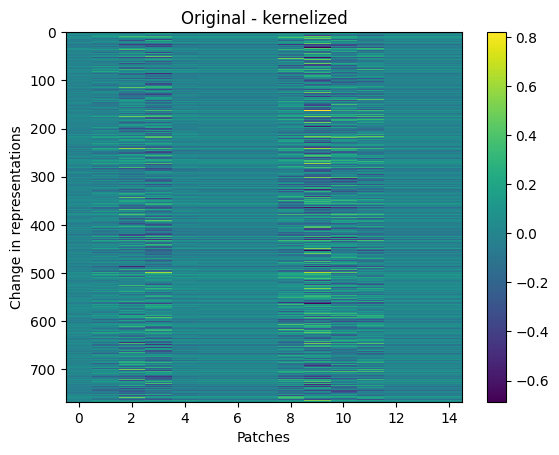

In [73]:
def plot_localize_origvskernelized_layer0(img_name, dataset, split, subset=None):
    layer = 0
    # epsilon = 1e-1

    # 1. Get original representation
    img_id = img_name.replace(".png", "")
    orig_z = torch.from_numpy(reprs[img_id][layer])
    orig_z = torch.squeeze(orig_z)
    
    # 2. Get kernelized representation
    kernel_z = get_kernelized_img_layer0("poly", img_name, dataset, split)

    # 3. Compute the difference between these two representations
    difference = orig_z.T.detach().numpy()-kernel_z.T.detach().numpy()

    if subset is not None:
        bb_patches = get_all_patches_with_objects(img_name, dataset, split)
        if subset == "no_objects":
            difference_patches = [difference[:, key] for key in range(50) if key-1 not in bb_patches.keys()]
            plt.title("Original - kernelized (black patches only)")
        elif subset == "only_objects":
            difference_patches = [difference[:, i+1] for i in bb_patches.keys()]
            plt.title("Original - kernelized (only object patches)")
        difference_patches = np.asarray(difference_patches).T
        plt.imshow(difference_patches, interpolation='nearest', aspect="auto")
    else:
        plt.imshow(difference[:, :15], interpolation='nearest', aspect="auto")
        plt.title("Original - kernelized")

    plt.colorbar()
    plt.xlabel("Patches")
    plt.ylabel("Change in representations")
    plt.show()

plot_localize_origvskernelized_layer0("1.png", "pos", "train", subset=None)

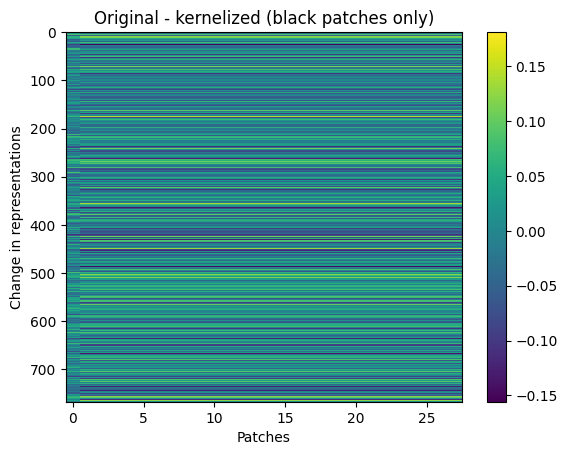

In [ ]:
plot_localize_origvskernelized_layer0("1.png", "pos", "train", subset="no_objects")

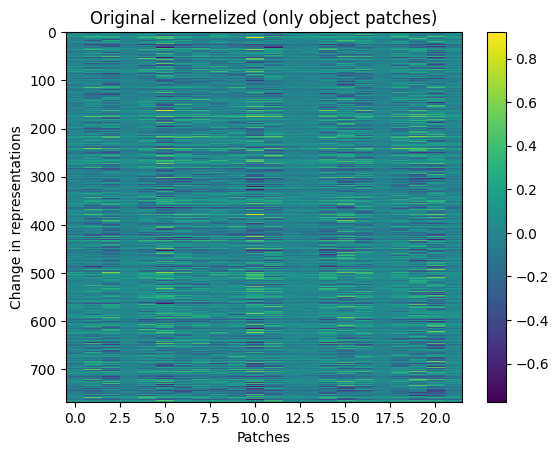

In [74]:
plot_localize_origvskernelized_layer0("1.png", "pos", "train", subset="only_objects")